In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Table of Contents

1. [Basic 1a](#Basic-1a)
2. [Basic 1b](#Basic-1b)
3. [Basic 1c](#Basic-1c)
4. [Basic 2a](#Basic-2a)
5. [Basic 2b](#Basic-2b)
6. [Basic 2c](#Basic-2c)
7. [Basic 3a](#Basic-3a)
8. [Basic 3b](#Basic-3b)

# Basic 1b

Stata code:
```stata
statsby _b _se N=e(N) N_clust=e(N_clust), by(tArea) ///
	saving("${taboutdir}/2. OLS/OLS_Basic1b_`set'_`dvar'_`samp'", replace): ///
	reg `dvar' ib2010.year ///
	ib11.tUni ///
	ib4.Type ///
	math math2 read read2 ///
	exp exp2   ///
	if `samp'==1 & `set'==1 & admit==1, cluster(${rutname}) baselevels
```

In [2]:
#%% Preamble
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as st
import seaborn as sns
import statsmodels.formula.api as sm
from matplotlib import cbook, colors
from matplotlib.colors import Normalize

#%% Define class to normalize cmap:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

#%% Define important variables
yesnomap = ['Reds', 'Blues']
zscore = st.norm.ppf(.975) # Note that 1.96 is the zscore inside of which is 95% of the data (ignoring both tails), but st.norm.ppf() gives the zscore which has 95% of the data below it (ignoring only the upper tail).
estsdir = '../estimations'
inputsdir = '../inputs'
Area_labels = ["Business and Administration", 
               "Agriculture", 
               "Architecture and Art", 
               "Natural Sciences", 
               "Social Sciences", 
               "Law", 
               "Education", 
               "Humanities", 
               "Health", 
               "Technology"]


We plot the coefficients for `math` and `read`. Their quadratic counterparts are plotted below, because of the difference in scale. 

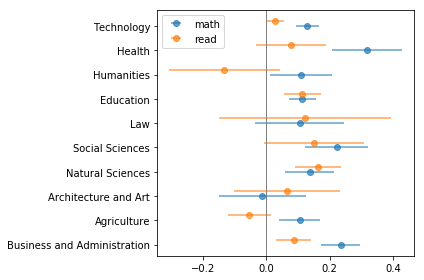

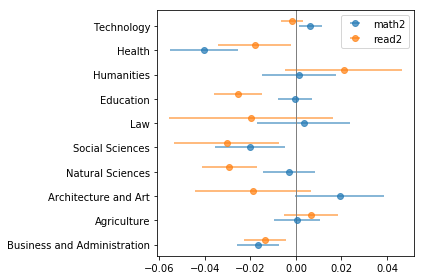

In [3]:
# Import data
os.path.join(estsdir,'OLS_Basic1b_All_ltotinc_tc_All.dta')
df = pd.read_stata(os.path.join(estsdir,'OLS_Basic1b_All_ltotinc_tc_All.dta'))
itr = pd.read_stata(os.path.join(estsdir,'OLS_Basic1b_All_ltotinc_tc_All.dta'), iterator = True)
itr.variable_labels()
df.reset_index(inplace=True)
# Plot coefficients
for degree in ['','2']:
    # math and read in same graph:
    for idx,coef in enumerate(['math', 'read']):
        plt.errorbar(df['_b_'+coef+degree], df.index+idx/5, xerr=df['_se_'+coef+degree]*zscore, marker='o', ls='none', label=coef+degree, alpha=0.7)
        plt.axvline(x=0, linewidth=1, color='grey')
        plt.yticks(df.index, Area_labels)
        plt.legend()
        plt.tight_layout()
    plt.show()

`exp` and `exp2` estimated coefficients are plotted in the same graph. Notice how there are two different $x$-axis.

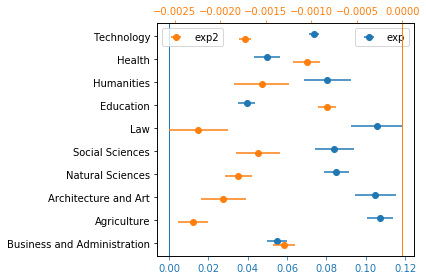

In [4]:
# exp in separate graph
fig, ax1 = plt.subplots()
ax1.errorbar(df['_b_exp'], df.index+.1, xerr=df['_se_exp']*zscore, marker='o', ls='none', label='exp', color='tab:blue')
ax1.set_xlabel('', color='tab:blue')
ax1.tick_params('x', colors='tab:blue')
plt.axvline(x=0, linewidth=1, color='tab:blue')
plt.legend()
ax2 = ax1.twiny()
ax2.errorbar(df['_b_exp2'], df.index-.1, xerr=df['_se_exp2']*zscore, marker='o', ls='none', label = 'exp2', color='tab:orange')
ax2.set_xlabel('', color='tab:orange')
ax2.tick_params('x', colors='tab:orange')
plt.axvline(x=0, linewidth=1, color='tab:orange')
plt.legend()
plt.yticks(df.index, Area_labels)
fig.tight_layout()
plt.show()

## Basic 1c

Stata code:
```stata
// Basic Regressions 1c : Get beta by Area and Selectivity controling for student Xs
statsby _b _se N=e(N) N_clust=e(N_clust), by(tArea tsel_q) ///
	saving("${taboutdir}/2. OLS/OLS_Basic1c_`set'_`dvar'_`samp'", replace): ///
	reg `dvar' ib2010.year ///
	ib11.tUni ///
	ib4.Type ///
	math math2 read read2 ///
	exp exp2   ///
	if `samp'==1 & `set'==1 & admit==1, cluster(${rutname}) baselevels
```

In [5]:
# Import data
df = pd.read_stata(os.path.join(estsdir,'OLS_Basic1c_All_ltotinc_tc_All.dta'))
itr = pd.read_stata(os.path.join(estsdir,'OLS_Basic1c_All_ltotinc_tc_All.dta'), iterator = True)
itr.variable_labels()
df.reset_index(inplace=True)

We plot `math`, `read` and `exp` estimated coefficients by target Area (`tArea`) and Selectivity terciles (`tsel_q`) (quadratic versions not plotted): 

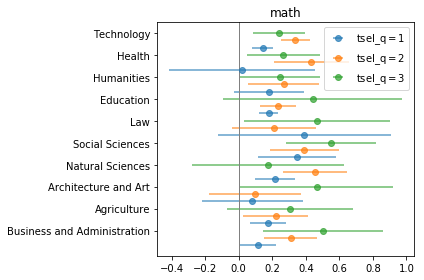

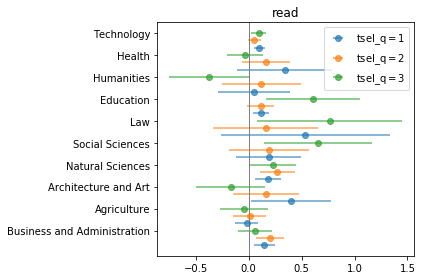

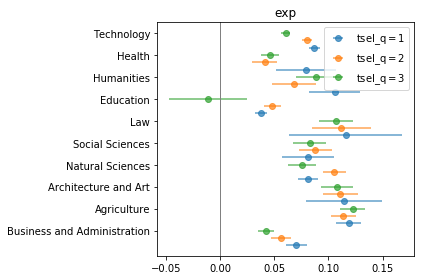

In [6]:
# Plot coefficients
for coef in ['math', 'read', 'exp']:
    for sgrp in range(min(df['tsel_q']),max(df['tsel_q'])+1):
        df_sgrp = df.loc[df['tsel_q'] == sgrp]
        plt.errorbar(df_sgrp['_b_'+coef], df_sgrp.index, xerr=df_sgrp['_se_'+coef]*zscore, marker='o', ls='none', label='tsel_q$={0}$'.format(sgrp), alpha=0.7)
        plt.axvline(x=0, linewidth=1, color='grey')
        plt.yticks(df_sgrp.index, Area_labels)
        plt.legend()
        plt.title(coef)
        plt.tight_layout()
    plt.show()

# Basic 2a

Stata code:
```stata
// Basic Regressions 2a : Get FL FE controling for student Xs
statsby _b _se N=e(N), ///
	saving("${taboutdir}/2. OLS/OLS_Basic2a_`set'_`dvar'_`samp'", replace): ///
	reg `dvar' ib11.tUni ibn.tFLcode ///
	ib4.Type ///
	math math2 read read2 ///
	exp exp2   ///
	if `samp'==1 & `set'==1 & admit==1, cluster(${rutname}) nocon baselevels
```

In [3]:
# Import data
df = pd.read_stata(os.path.join(estsdir,'OLS_Basic2a_All_ltotinc_tc_All.dta'))
itr = pd.read_stata(os.path.join(estsdir,'OLS_Basic2a_All_ltotinc_tc_All.dta'), iterator = True)
itr.variable_labels()
df.reset_index(inplace=True)

# Basic 2b

Stata code:
```stata
statsby _b _se N=e(N) N_clust=e(N_clust), by(tFLcode) ///
	saving("${taboutdir}/2. OLS/OLS_Basic2b_`set'_`dvar'_`samp'", replace): ///
	reg `dvar' ib2010.year ///
	ib11.tUni ///
	ib4.Type ///
	math math2 read read2 ///
	exp exp2   ///
	if `samp'==1 & `set'==1 & admit==1, cluster(${rutname}) baselevels
```

Below we plot estimated coefficients for `math` and `read`, which were computed by target FL code (`tFLcode`).
FL codes are sorted by the proportion of related courses for each score:
- `math` coefficients by FL code are sorted by proportion of _quantitative_ courses.
- `read` coefficients by FL code are sorted by proportion of _qualitative_ courses.

Error bars were omitted to reduce the plots' noise, but each point's color is mapped to the corresponding $t$-statistic.

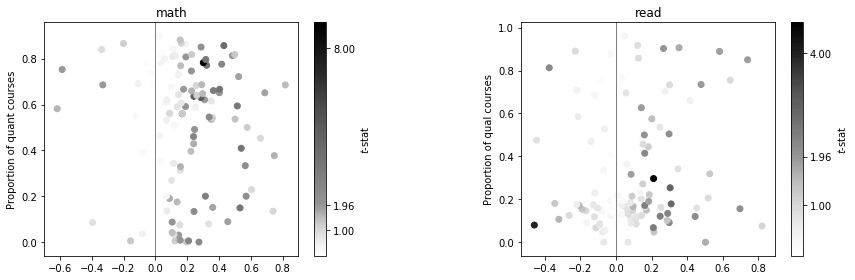

In [129]:
#%% 1b: math, read
fig = plt.figure(figsize=(12, 4))
for i, (coef, q) in enumerate({'math':'Pquant', 'read':'Pqual'}.items()):
    # Import estimations:
    df = pd.read_stata(os.path.join(estsdir, 'OLS_Basic2b_All_ltotinc_tc_All.dta'))

    # Import and merge FL codes information:
    FL = pd.read_stata(os.path.join(inputsdir, 'mallas.dta'))
    df = df.merge(FL, left_on='tFLcode_app', right_on='FLcode_app', how='left')

    # Add confidence intervals, t-stats and significance dummy:
    df['ci_'+coef] = df['_se_'+coef]*zscore;
    df['lb_'+coef] = df['_b_'+coef] - df['ci_'+coef]
    df['ub_'+coef] = df['_b_'+coef] + df['ci_'+coef]
    df['t_'+coef] = abs(df['_b_'+coef]) / df['_se_'+coef]
    df['signf_'+coef] = (df['lb_'+coef] > 0) | (df['ub_'+coef] < 0)

    # Remove outlier
    df = df.loc[(df['_b_'+coef] > df['_b_'+coef].quantile(q=0.025)) & (df['_b_'+coef] < df['_b_'+coef].quantile(q=0.975))]
    df = df.sort_values(by=[q])
    df = df.reset_index(drop=True)

    # Plot:
    ax = fig.add_subplot(1,2,i+1)
    scat = ax.scatter(df['_b_'+coef],df[q], c=df['t_'+coef], cmap='Greys', norm=MidpointNormalize(midpoint=1.96))
    fig.colorbar(scat, label='$t$-stat', ticks=[math.ceil(min(df['t_'+coef])), zscore,math.floor(max(df['t_'+coef]))])
    ax.axvline(x=0, linewidth=1, color='grey')
    plt.title(coef)
    plt.ylabel('Proportion of ' + q[1:] + ' courses')
    
plt.tight_layout()
fig.subplots_adjust(wspace=.5)
plt.show()

# Basic 2c

Stata code:
```stata
statsby _b _se N=e(N) N_clust=e(N_clust), by(tFLcode tsel_q) ///
	saving("${taboutdir}/2. OLS/OLS_Basic2c_`set'_`dvar'_`samp'", replace): ///
	reg `dvar' ib2010.year ///
	ib11.tUni ///
	ib4.Type ///
	math math2 read read2 ///
	exp exp2   ///
	if `samp'==1 & `set'==1 & admit==1, cluster(${rutname}) baselevels
```

Below we plot estimated coefficients for `math` and `read`, which were computed by target FL code (`tFLcode`).
FL codes are sorted by the proportion of related courses for each score:
- `math` coefficients by FL code are sorted by proportion of _quantitative_ courses.
- `read` coefficients by FL code are sorted by proportion of _qualitative_ courses.

Error bars were omitted to reduce the plots' noise, but each point's color is mapped to the corresponding $t$-statistic.
Each row corresponds to different Selectivity terciles.

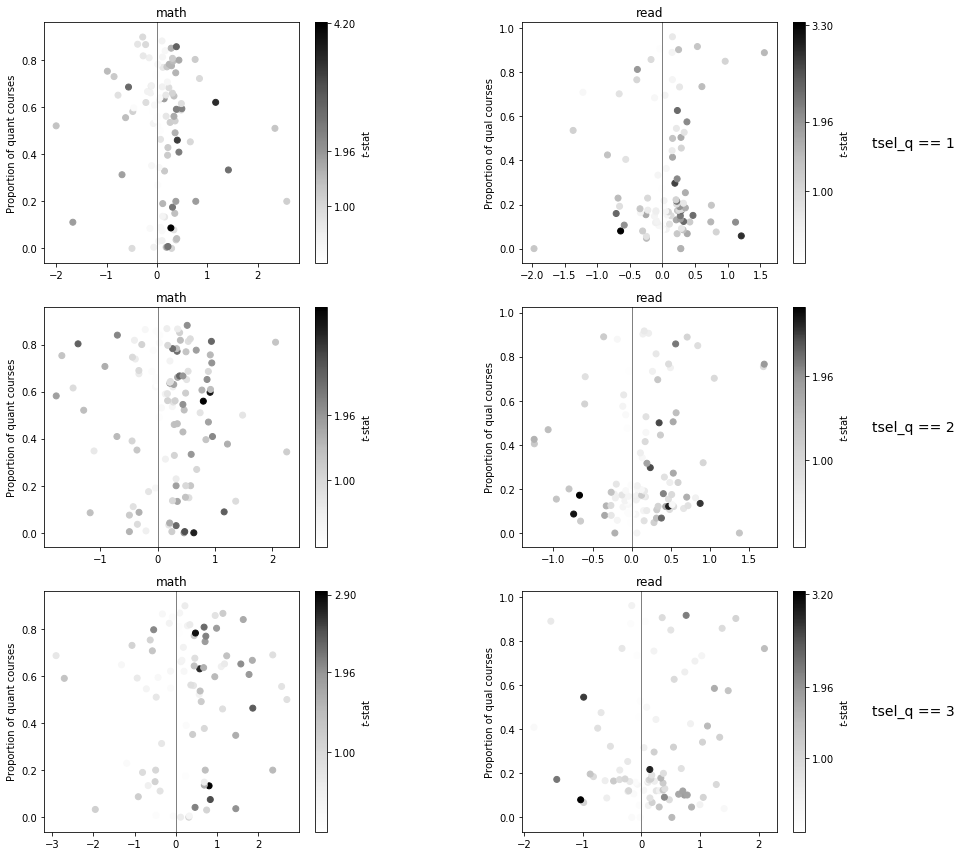

In [130]:
#%% 1c: math, read
fig = plt.figure(figsize=(12, 12))
index = 0
for tsel in [1,2,3]:
    for i, (coef, q) in enumerate({'math':'Pquant', 'read':'Pqual'}.items()):
        # Import estimations:
        df = pd.read_stata(os.path.join(estsdir, 'OLS_Basic2c_All_ltotinc_tc_All.dta'))

        # Import and merge FL codes information:
        FL = pd.read_stata(os.path.join(inputsdir, 'mallas.dta'))
        df = df.merge(FL, left_on='tFLcode_app', right_on='FLcode_app', how='left')

        # Add confidence intervals, t-stats and significance dummy:
        df['ci_'+coef] = df['_se_'+coef]*zscore;
        df['lb_'+coef] = df['_b_'+coef] - df['ci_'+coef]
        df['ub_'+coef] = df['_b_'+coef] + df['ci_'+coef]
        df['t_'+coef] = abs(df['_b_'+coef]) / df['_se_'+coef]
        df['signf_'+coef] = (df['lb_'+coef] > 0) | (df['ub_'+coef] < 0)

        # Remove outlier and filter data by Selectivity tercile
        df = df.loc[(df['_b_'+coef] > df['_b_'+coef].quantile(q=0.025)) & (df['_b_'+coef] < df['_b_'+coef].quantile(q=0.975))]
        df = df[(df['tsel_q'] == tsel)]
        df = df.sort_values(by=[q])
        df = df.reset_index(drop=True)

        # Plot:
        ax = fig.add_subplot(3,2,index+1)
        scat = ax.scatter(df['_b_'+coef],df[q], c=df['t_'+coef], cmap='Greys', norm=MidpointNormalize(midpoint=1.96))
        fig.colorbar(scat, label='$t$-stat', ticks=[math.ceil(min(df['t_'+coef])), zscore,round(max(df['t_'+coef]), 1)])
        ax.axvline(x=0, linewidth=1, color='grey')
        plt.title(coef)
        plt.ylabel('Proportion of ' + q[1:] + ' courses')
        index += 1
    
    # Add row label to indicate Selectivity tercile
    plt.text(x = 1.7, y = .5, s = 'tsel_q == ' + str(tsel), fontsize=14, rotation = 0, ha = "right", va = 'center', transform=ax.transAxes)
    
plt.tight_layout()
fig.subplots_adjust(wspace=.5)
plt.show()

# Basic 3a

Stata code:
```stata
// Basic Regressions By Demre Code (university major sede combo)
statsby _b _se N=e(N) N_clust=e(N_clust),  ///
	saving("${taboutdir}/2. OLS/OLS_Basic3a_`set'_`dvar'_`samp'", replace): ///
	reg `dvar' ib2010.year ///
	ibn.tFLUNISEDE ///
	ib4.Type ///
	math read ///
	exp exp2   ///
	if `samp'==1 & `set'==1 & admit==1, cluster(${rutname}) nocon baselevels
```

# Basic 3b

Stata code:
```stata
// Basic Regressions By Demre Code (university major sede combo)
statsby _b _se N=e(N) N_clust=e(N_clust), by(tFLUNISEDE) ///
	saving("${taboutdir}/2. OLS/OLS_Basic3b_`set'_`dvar'_`samp'", replace): ///
	reg `dvar' ib2010.year ///
	ib4.Type ///
	math read ///
	exp exp2   ///
	if `samp'==1 & `set'==1 & admit==1, cluster(${rutname}) baselevels
```